In [18]:
import torch
import numpy as np
import matplotlib.pyplot as plt

import torch.optim as optim
import torch.nn as nn

from qibo import (
    Circuit, 
    gates, 
    hamiltonians, 
    set_backend, 
    construct_backend,
)
from qibo.ui.result_visualization import visualize_state

from qiboml.models.encoding import PhaseEncoding
from qiboml.models.decoding import Expectation
from qiboml.interfaces.pytorch import QuantumModel
from qiboml.operations.differentiation import PSR, Jax

In [19]:
nqubits = 4
nlayers = 3

In [20]:
# Structure of the VQE ansatz
def build_vqe_circuit(nqubits, nlayers):
    c = Circuit(nqubits)
    for _ in range(nlayers):
        for q in range(nqubits):
            c.add(gates.RY(q=q, theta=np.random.randn()))
            c.add(gates.RZ(q=q, theta=np.random.randn()))
        [c.add(gates.CNOT(q0=q%nqubits, q1=(q+1)%nqubits)) for q in range(nqubits)]
    return c

In [21]:
# Define the target Hamiltonian
hamiltonian = hamiltonians.XXZ(nqubits=nqubits, delta=0.5)

# Construct the decoding layer
decoding = Expectation(
    nqubits=nqubits,
    observable=hamiltonian,
    # backend=construct_backend("qiboml", platform="pytorch")
    backend = construct_backend("numpy")
)

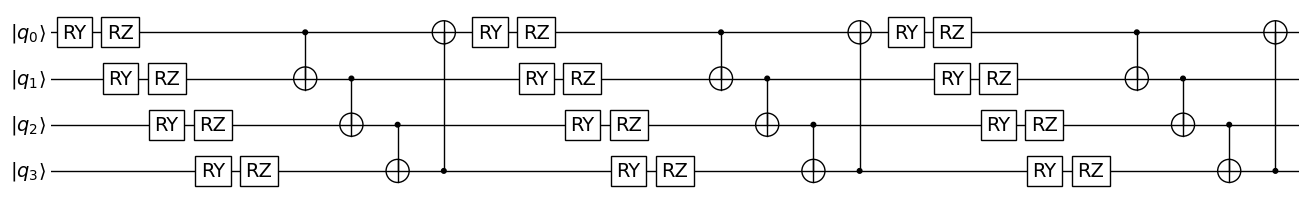

In [22]:
model = QuantumModel(
    circuit_structure=build_vqe_circuit(nqubits=nqubits, nlayers=nlayers),
    decoding=decoding,
    differentiation=PSR(),
)

_ = model.draw()

In [23]:
print("Exact ground state: ", min(hamiltonian.eigenvalues()))

Exact ground state:  tensor(-6.7446, dtype=torch.float64)


In [24]:
optimizer = optim.Adam(model.parameters(), lr=0.05)

for iteration in range(200):
    optimizer.zero_grad()  
    cost = model()  
    cost.backward()  
    optimizer.step()  

    if iteration % 20 == 0:
        print(f"Iteration {iteration}: Cost = {cost.item():.6f}")

AttributeError: 'NoneType' object has no attribute 'clone'